# I. Import Libraries

In [1]:
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.utils import shuffle
import xgboost as xgb
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

***
# II. Read in Data and Engineer Additional Features

In [2]:
# Connect to the sqlite database and read the tables into pandas dataframe objects
conn = sqlite3.connect('coffee.db')
cursor = conn.cursor()

snd_tbl_query = "SELECT * FROM SND"
coffee_type_tbl_query = "SELECT * FROM coffee_type"
market_tbl_query = "SELECT * FROM market"
price_tbl_query = "SELECT * FROM price"

df_snd = pd.read_sql_query(snd_tbl_query, conn)
df_coffee_type = pd.read_sql_query(coffee_type_tbl_query, conn)
df_market = pd.read_sql_query(market_tbl_query, conn)
df_price = pd.read_sql_query(price_tbl_query, conn)

conn.close()

In [3]:
# Convert date columns from 'object' type to 'datetime64' type
df_snd['date'] = pd.to_datetime(df_snd['date'], format='%Y-%m-%d')
df_market['date'] = pd.to_datetime(df_market['date'], format='%Y-%m-%d')
df_price['date'] = pd.to_datetime(df_price['date'], format='%Y-%m-%d')

In [4]:
# Join all data into one dataframe
df = df_snd.merge(df_market, on=['date'], how='left') \
           .merge(df_price, on=['date','coffee_type_id','actvsproj'],how='left') \
           .merge(df_coffee_type, on=['coffee_type_id'], how='left')

In [5]:
# Generate month and season features
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['month'] = df['date'].dt.month
df['season'] = df['month'].apply(get_season)

In [6]:
df.head()

,date,coffee_type_id,certified_stock,total_consumption,total_stock,total_supply,total_demand,actvsproj,DXY,USDBRL,price,coffee_type,month,season
0,2001-12-31,1,1114.557832,4792.057525,4459.483456,1568.443583,785.610628,act,116.750000,2.311,48.15,Arabica,12,Winter
1,2002-01-31,1,1087.076160,4861.908518,4558.069021,1594.259096,744.775122,act,120.239998,2.413,47.65,Arabica,1,Winter
2,2002-02-28,1,1026.468713,4349.975139,4406.522032,1567.154395,769.710533,act,119.160004,2.365,46.30,Arabica,2,Winter
3,2002-03-31,1,961.625592,4647.049927,4120.613079,1518.538160,806.831154,act,118.620003,2.325,59.20,Arabica,3,Spring
4,2002-04-30,1,892.695043,4755.849295,3905.861783,1479.966651,806.272717,act,115.190002,2.361,52.85,Arabica,4,Spring


***
# III. Data Vizualization Dashboard

#### Features:
* <u>Date</u>: recorded at the end of each month
* <u>Certified Stock</u>: commodity inventory that has been inspected by qualified representatives and determined the basis of grade for use in futures market trading
* <u>Total Consumption</u>: coffee consumption over the past month
* <u>Total Stock</u>: coffee reserves
* <u>Total Supply</u>: coffee amount available to market over the past month
* <u>Total Demand</u>: coffee amount wanted for purchase by customers over the past month
* <u>Act vs Proj</u>: denotes if data sample is actual or projected/forecasted
* <u>DXY</u>: US Dollar Index, a measure of the dollar against six other major currencies
* <u>USDBRL</u>: USD to BRL (Brazil Real) Exchange Rate, Brazil is the world's largest coffee producer by a large margin
* <u>Price</u>: price of coffee (currency per what?)
* <u>Coffee Type</u>: Arabica or Robusta
* <u>Month</u>: 1->January, ... , 12-> December
* <u>Season</u>: Winter, Spring, Summer, Fall

Note: some of these feature definitions are my best guesses. I performed this exercise to better understand the data.

### Plot 1: Coffee Price Over Time

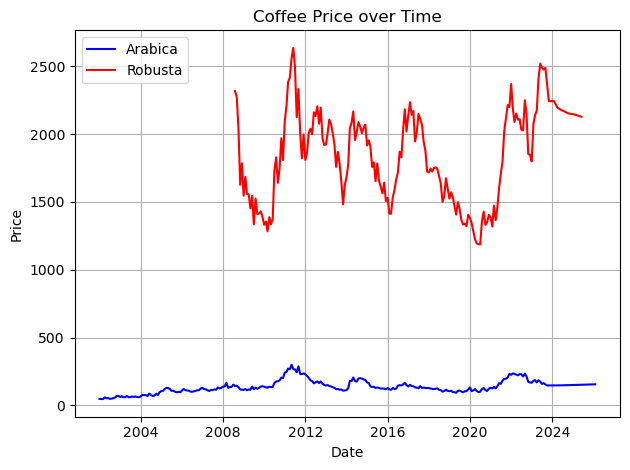

In [7]:
type1_data = df[df['coffee_type'] == 'Arabica']
plt.plot(type1_data['date'], type1_data['price'], label='Arabica', color='blue')

type2_data = df[df['coffee_type'] == 'Robusta']
plt.plot(type2_data['date'], type2_data['price'], label='Robusta', color='red')

plt.title("Coffee Price over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

***
### Plot 2: Average Supply, Demand, Stock and Consumption over the past 3 years grouped by month and coffee type

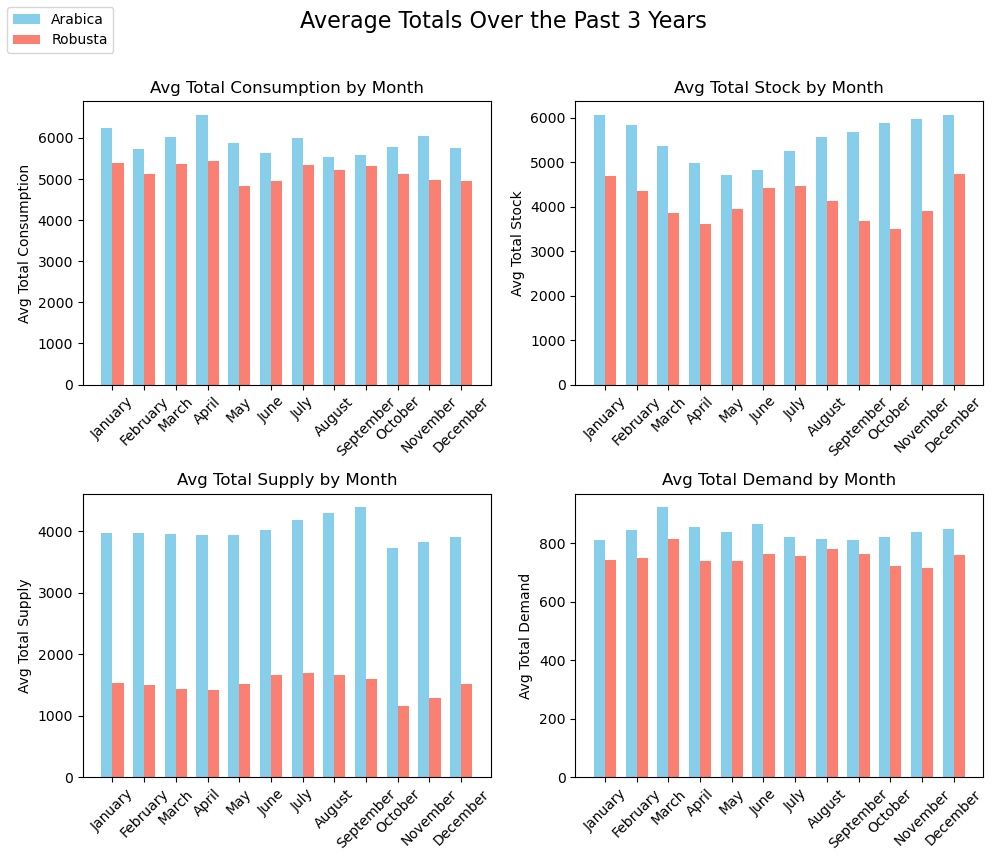

In [8]:
three_years_ago = datetime.now() - timedelta(days=3*365)
df_3y = df[df['date'] >= three_years_ago]
df_3y = df_3y[df_3y['date'] <= datetime.now()]

grouped = df_3y.groupby([df_3y['date'].dt.month, 'coffee_type'])[['total_consumption', 'total_stock', 'total_supply', 'total_demand']] \
            .mean().reset_index()

month_map = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

grouped['month_name'] = grouped['date'].map(month_map)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

bar_width = 0.35
index = range(len(grouped['month_name'].unique()))

features = ['total_consumption', 'total_stock', 'total_supply', 'total_demand']
colors = ['skyblue', 'salmon']

for i, feature in enumerate(features):
    ax = axs[i//2, i%2]
    
    bar1 = [pos - bar_width/2 for pos in index]
    bar2 = [pos + bar_width/2 for pos in index]
    
    arabica_data = grouped[grouped['coffee_type'] == 'Arabica']
    robusta_data = grouped[grouped['coffee_type'] == 'Robusta']

    ax.bar(bar1, arabica_data[feature], color=colors[0], width=bar_width, label='Arabica')
    ax.bar(bar2, robusta_data[feature], color=colors[1], width=bar_width, label='Robusta')
    
    parsed_feature = " ".join([word.capitalize() for word in feature.split("_")])
    ax.set_title(f"Avg {parsed_feature} by Month")
    ax.set_ylabel("Avg "+parsed_feature)
    ax.set_xticks(index)
    ax.set_xticklabels(grouped['month_name'].unique(), rotation=45)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', fontsize='medium', ncol=1)

plt.tight_layout()
fig.suptitle("Average Totals Over the Past 3 Years", fontsize=16, y=1.07)

plt.show()

***
### Plot 3: US Dollar Index & USD to BRL Exchange Rate values over time

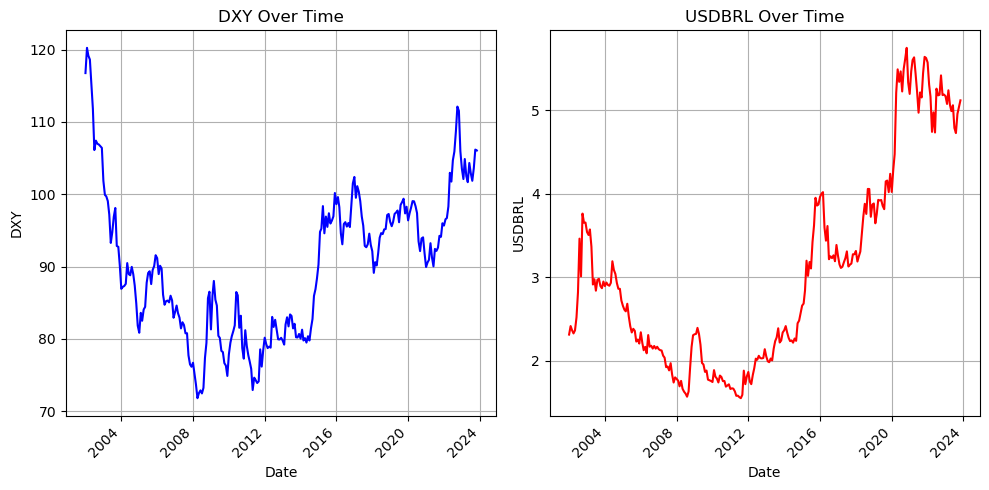

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

df_market_act = df_market.query('actvsproj=="act"')

# Plot DXY value over time
axs[0].plot(df_market_act['date'], df_market_act['DXY'], color='blue', label='DXY')
axs[0].set_title("DXY Over Time")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("DXY")
axs[0].grid(True)

# Plot USDBRL value over time
axs[1].plot(df_market_act['date'], df_market_act['USDBRL'], color='red', label='USDBRL')
axs[1].set_title("USDBRL Over Time")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("USDBRL")
axs[1].grid(True)

fig.autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()

***
# IV. Forcasting Coffee Prices

### Train two models, one for each coffee type (Arabica and Robusta)

#### Model objective: predict the next month's coffee price
#### Features used to train in models:
- certified_stock
- total_consumption
- total_stock
- total_supply
- total_demand
- DXY
- USDBRL
- price (current month)
- month

In [10]:
df_act = df.query('actvsproj=="act"')
df_act = df_act.drop(['actvsproj', 'coffee_type_id','season'], axis=1)

df_act['target'] = df_act['price'].shift(-1) # Lead target price by one month
df_act = df_act[df_act['date'] != '2023-10-31'] # Remove most recent date since it will have NaN value for target

df_act = shuffle(df_act, random_state=1)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbosity': 1,
    'lambda': 10,
    'alpha': 0.5
}

num_round = 500
early_stopping_rounds = 10

coffee_types = ['Arabica', 'Robusta']
models = {}

for coffee in coffee_types:
    print(f"\033[1mTraining {coffee} Model:\033[0m")
    filtered_df = df_act[df_act['coffee_type'] == coffee].copy()
    filtered_df.drop(['coffee_type'], axis=1,inplace=True)
    
    train_size = int(len(filtered_df) * 0.7)
    train_df, test_df = filtered_df.iloc[:train_size], filtered_df.iloc[train_size:]

    X_train = train_df.drop(columns=['target', 'date'])
    y_train = train_df['target']
    X_test = test_df.drop(columns=['target', 'date'])
    y_test = test_df['target']

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    evals = [(dtrain, 'train'), (dvalid, 'eval')]

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=10
    )

    models[coffee] = model
    print(f"Best iteration for {coffee}: {model.best_iteration}\n")

Training Arabica Model:
[0]	train-rmse:46.83005	eval-rmse:48.12342
[10]	train-rmse:35.50389	eval-rmse:36.26571
[20]	train-rmse:27.70089	eval-rmse:28.32876
[30]	train-rmse:22.67810	eval-rmse:23.60940
[40]	train-rmse:18.82904	eval-rmse:19.76169
[50]	train-rmse:16.09110	eval-rmse:17.12982
[60]	train-rmse:14.30257	eval-rmse:15.41497
[70]	train-rmse:13.04342	eval-rmse:14.24362
[80]	train-rmse:12.18057	eval-rmse:13.56204
[90]	train-rmse:11.57500	eval-rmse:13.32871
[100]	train-rmse:11.10035	eval-rmse:13.06575
[110]	train-rmse:10.72726	eval-rmse:12.84286
[120]	train-rmse:10.39874	eval-rmse:12.76173
[130]	train-rmse:10.16388	eval-rmse:12.72712
[133]	train-rmse:10.10019	eval-rmse:12.72838
Best iteration for Arabica: 123

Training Robusta Model:
[0]	train-rmse:318.95750	eval-rmse:346.63924
[10]	train-rmse:249.19074	eval-rmse:274.86728
[20]	train-rmse:201.76867	eval-rmse:226.96464
[30]	train-rmse:174.82664	eval-rmse:198.74923
[40]	train-rmse:151.17547	eval-rmse:174.06366
[50]	train-rmse:135.29125	

### Plot the predicted and actual prices

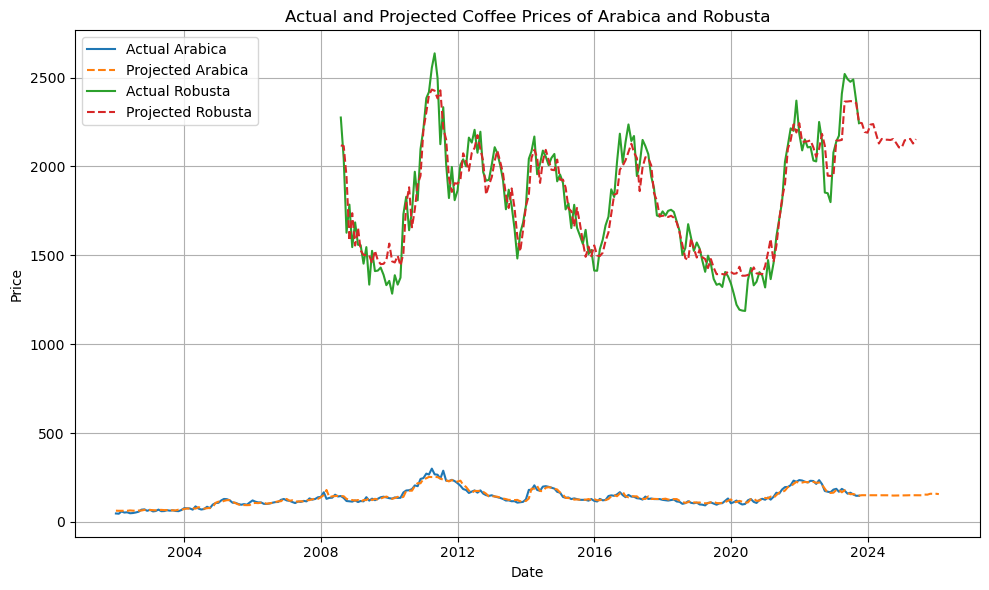

In [11]:
df_all = df.copy()
df_all = df_all.drop(['actvsproj', 'coffee_type_id','season'], axis=1)

df_all['target'] = df_all['price'].shift(-1)
df_all.loc[df_all['date'] >= '2023-10-31', 'target'] = np.nan

predictions = {}

for coffee in coffee_types:
    model = models[coffee]
    
    # Filter the testing data for the specific coffee type and sort by date
    test_data = df_all[df_all['coffee_type'] == coffee].sort_values(by='date')
    
    # Set 'target' to np.nan where 'date' is greater than or equal to '2023-10-31'
    test_data.loc[test_data['date'] >= '2023-10-31', 'target'] = np.nan
    
    X_test = test_data.drop(columns=['target', 'date', 'coffee_type'])
    y_test_actual = test_data['target'].values
    test_dates = test_data['date'].values
    
    # Predict the prices using XGBoost model
    dtest = xgb.DMatrix(X_test)
    y_test_pred = model.predict(dtest)
    
    predictions[coffee] = {
        'dates': test_dates,
        'actual': y_test_actual,
        'predicted': y_test_pred
    }

plt.figure(figsize=(10, 6))

for coffee in coffee_types:
    plt.plot(predictions[coffee]['dates'], predictions[coffee]['actual'], label=f'Actual {coffee}')
    plt.plot(predictions[coffee]['dates'], predictions[coffee]['predicted'], linestyle='--', label=f'Projected {coffee}')

plt.title('Actual and Projected Coffee Prices of Arabica and Robusta')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

***
# V. Future Considerations
1. Add features of the price in previous months, instead of only the current month.
2. Quantile regression to generate prediction confidence intervals.
3. Try a basic time series model like ARIMA and compare performance to current. One could also try a RNN time-series model, but this is likely to overfit on the small dataset.